In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Problem Definition

- The United States has been massively increasing construction in recent years, but there is a shortcoming in spending construction that can be detrimental to the country, find out if there is any anomalous data there?

# Data Preprocessing
---

In [4]:
def read_data(path):
    """
    Reads a CSV file at the given path, removes any duplicate rows,
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        The sample data input path (csv format)

    Return
    ------
    df : pd.DataFrame
        The sample data input
    """
    # List of encodings to try
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

    # Attempt to read the file with each encoding
    for encoding in encodings:
        try:
            df = pd.read_csv(path, encoding=encoding)
            # Remove duplicate rows
            df.drop_duplicates(inplace=True)
            # Print data shape for validation
            print('Data shape after removing duplicates:', df.shape)
            return df
        except UnicodeDecodeError:
            print(f"Failed to read with encoding '{encoding}'. Trying next...")

    # If all encodings fail
    raise ValueError("Failed to read the CSV file. None of the specified encodings worked.")

In [5]:
df = read_data(path = 'Downloads/PRCMUCONS.csv')

Data shape after removing duplicates: (377, 2)


In [6]:
df.head()

,DATE,PRCMUCONS
0,1993-01-01,9629.0
1,1993-02-01,9483.0
2,1993-03-01,10089.0
3,1993-04-01,9387.0
4,1993-05-01,9630.0


In [7]:
df.columns

Index(['DATE', 'PRCMUCONS'], dtype='object')

In [8]:
# check nulls
df.isnull().sum()

DATE         0
PRCMUCONS    0
dtype: int64

In [9]:
# change dtype
df['DATE'] = pd.to_datetime(df['DATE'])

In [10]:
df.dtypes

DATE         datetime64[ns]
PRCMUCONS           float64
dtype: object

In [11]:
# sanichek
print('Max Data', df['DATE'].max())
print('Min Data', df['DATE'].min())

Max Data 2024-05-01 00:00:00
Min Data 1993-01-01 00:00:00


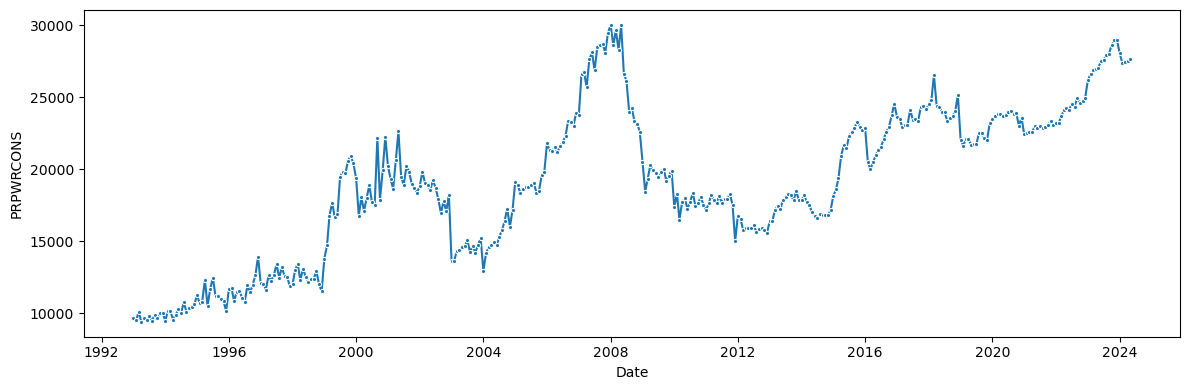

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x='DATE', y='PRCMUCONS', marker='.', data=df, ax=ax)

# Atur label sumbu x dan y
ax.set_xlabel('Date')
ax.set_ylabel('PRPWRCONS')

plt.tight_layout()
plt.show()

# Anomaly Detection with IQR
---

Here we can't find an anomaly, let's use a simple method, namely IQR

**Model 1**

In [16]:
def calculate_iqr_thresholds(data, column):
    """
    Calculate the IQR (Interquartile Range) and thresholds for anomaly detection based on the IQR method.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the data.
    column : str
        Name of the column in the DataFrame for which to calculate IQR and thresholds.

    Returns
    -------
    q1 : float
        First quartile (25th percentile) of the data.
    q3 : float
        Third quartile (75th percentile) of the data.
    iqr : float
        Interquartile range (IQR) of the data.
    max_bound : float
        Upper threshold based on the IQR method.
    min_bound : float
        Lower threshold based on the IQR method.
    """
    # Calculate quartiles and IQR
    q1 = np.quantile(data[column], q=0.25)
    q3 = np.quantile(data[column], q=0.75)
    iqr = q3 - q1

    # Calculate thresholds
    max_bound = q3 + 1.5 * iqr
    min_bound = q1 - 1.5 * iqr

    return q1, q3, iqr, max_bound, min_bound

In [17]:
q1, q3, iqr, max_bound, min_bound = calculate_iqr_thresholds(df, 'PRCMUCONS')

In [18]:
print('Q1 IQR  :', q1)
print('Q3 IQR  :', q3)
print('IQR     :', iqr)
print('Max. threshold:', max_bound)
print('Min. threshold:', min_bound)

Q1 IQR  : 15592.0
Q3 IQR  : 23039.0
IQR     : 7447.0
Max. threshold: 34209.5
Min. threshold: 4421.5


In [19]:
# Create a dot label outside the threshold
greater = df['PRCMUCONS'] > max_bound
lesser = df['PRCMUCONS'] < min_bound
df['anomaly'] = greater | lesser

In [20]:
# proportion
df.anomaly.value_counts(normalize=True)

anomaly
False    1.0
Name: proportion, dtype: float64

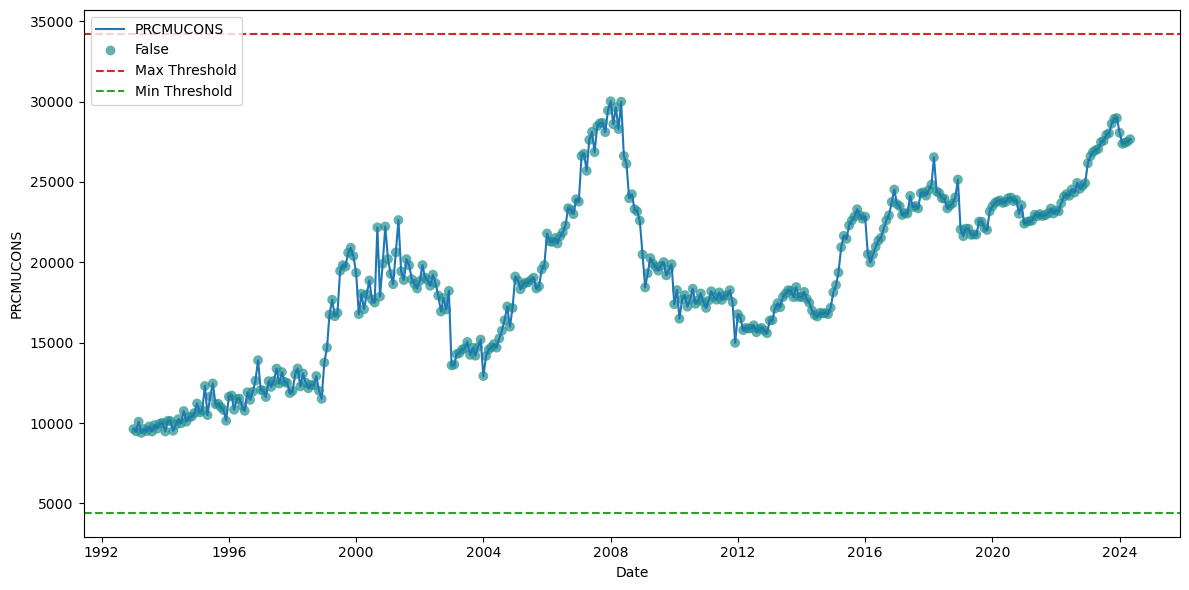

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot of sales over time
sns.lineplot(x='DATE', y='PRCMUCONS', data=df, ax=ax, label='PRCMUCONS')

# Scatter plot for anomaly status
sns.scatterplot(x='DATE', y='PRCMUCONS', hue='anomaly',
                data=df, palette='viridis', marker='o', s=50, alpha=0.7, 
                edgecolor='none', ax=ax, legend='full')

# Threshold lines
ax.axhline(max_bound, color='tab:red', linestyle='--', label='Max Threshold')
ax.axhline(min_bound, color='tab:green', linestyle='--', label='Min Threshold')

# Labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('PRCMUCONS')
ax.legend(loc='upper left')

# Display plot
plt.tight_layout()
plt.show()

This result is not convincing, we will try to see one by one

**Model 2 - Day by day**

In [24]:
df['comm_pct_change'] = df['PRCMUCONS'].pct_change(periods=1)
df['comm_pct_change'] = df['comm_pct_change'].fillna(0)
df

,DATE,PRCMUCONS,anomaly,comm_pct_change
0,1993-01-01,9629.0,False,0.000000
1,1993-02-01,9483.0,False,-0.015163
2,1993-03-01,10089.0,False,0.063904
3,1993-04-01,9387.0,False,-0.069581
4,1993-05-01,9630.0,False,0.025887
...,...,...,...,...
372,2024-01-01,28061.0,False,-0.031578
373,2024-02-01,27376.0,False,-0.024411
374,2024-03-01,27440.0,False,0.002338
375,2024-04-01,27506.0,False,0.002405


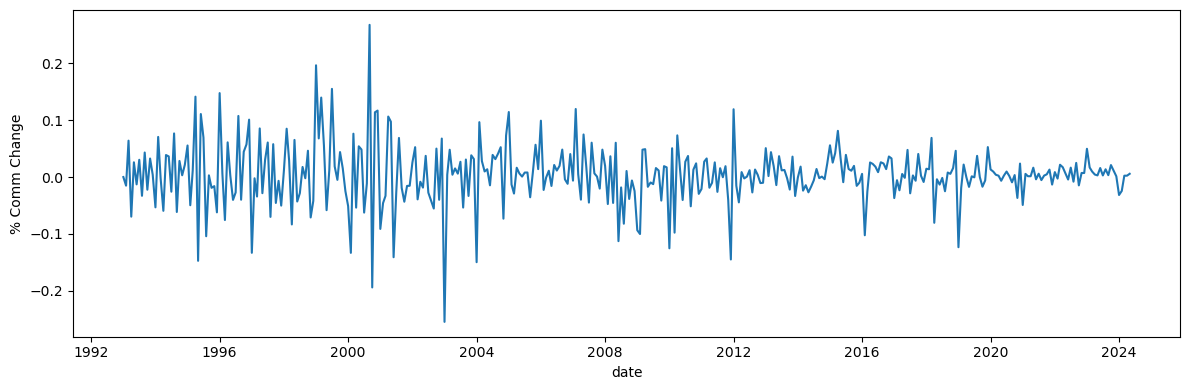

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x = df['DATE'],
             y = df['comm_pct_change'],
             ax = ax)

ax.set_xlabel('date')
ax.set_ylabel('% Comm Change')
plt.tight_layout()
plt.show()

In [26]:
# detect anomaly again
q1, q3, iqr, max_bound_pct, min_bound_pct = calculate_iqr_thresholds(df, 'comm_pct_change')

In [27]:
# Create a dot label outside the threshold
greater_1 = df['comm_pct_change'] > max_bound_pct
lesser_1 = df['comm_pct_change'] < min_bound_pct
df['anomaly_2'] = greater_1 | lesser_1

In [28]:
df.head()

,DATE,PRCMUCONS,anomaly,comm_pct_change,anomaly_2
0,1993-01-01,9629.0,False,0.000000,False
1,1993-02-01,9483.0,False,-0.015163,False
2,1993-03-01,10089.0,False,0.063904,False
3,1993-04-01,9387.0,False,-0.069581,False
4,1993-05-01,9630.0,False,0.025887,False


In [29]:
df['anomaly_2'].value_counts(normalize=True)

anomaly_2
False    0.907162
True     0.092838
Name: proportion, dtype: float64

We obtain anomaly 9.2%

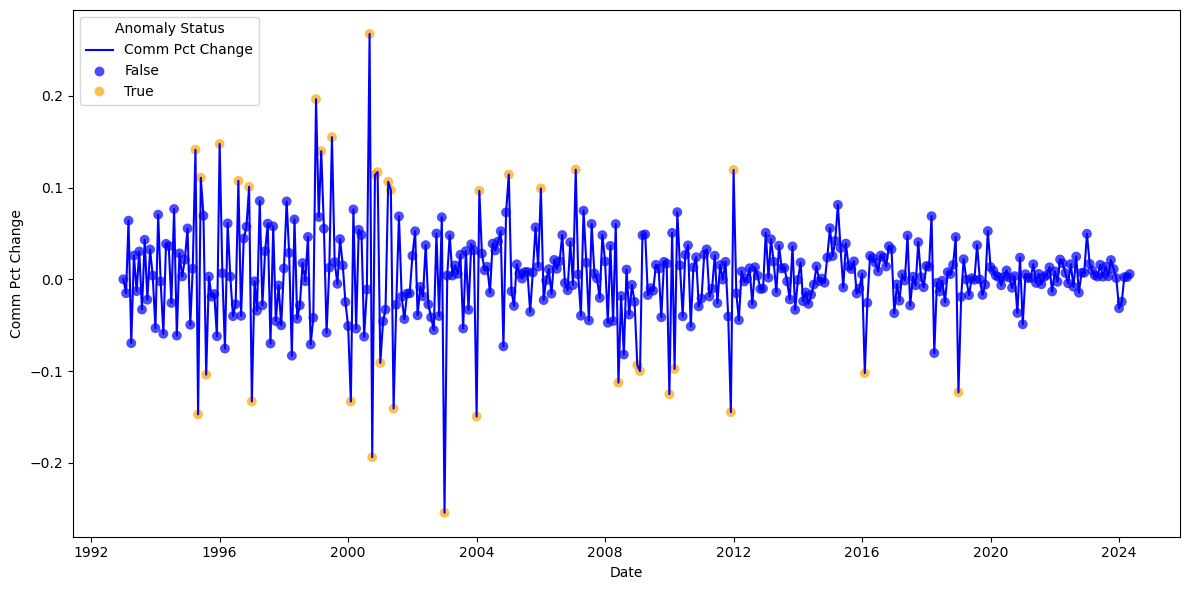

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot of comm_pct_change over time
sns.lineplot(x='DATE', y='comm_pct_change', data=df, ax=ax, color='b', label='Comm Pct Change')

# Scatter plot for anomaly status
sns.scatterplot(x='DATE', y='comm_pct_change', hue='anomaly_2', data=df, palette={True: 'orange', False: 'blue'}, ax=ax, legend='brief', marker='o', s=50, edgecolor='none', alpha=0.7)

# Labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('Comm Pct Change')
ax.legend(loc='upper left', title='Anomaly Status')

# Display plot
plt.tight_layout()
plt.show()

**Model 3 - Week by week**

If the variance of the last 7 days is large, then the anomaly

In [34]:
df['rolling_prcmucons'] = df['PRCMUCONS'].rolling(window=7).var()
df.head()

,DATE,PRCMUCONS,anomaly,comm_pct_change,anomaly_2,rolling_prcmucons
0,1993-01-01,9629.0,False,0.000000,False,NaN
1,1993-02-01,9483.0,False,-0.015163,False,NaN
2,1993-03-01,10089.0,False,0.063904,False,NaN
3,1993-04-01,9387.0,False,-0.069581,False,NaN
4,1993-05-01,9630.0,False,0.025887,False,NaN


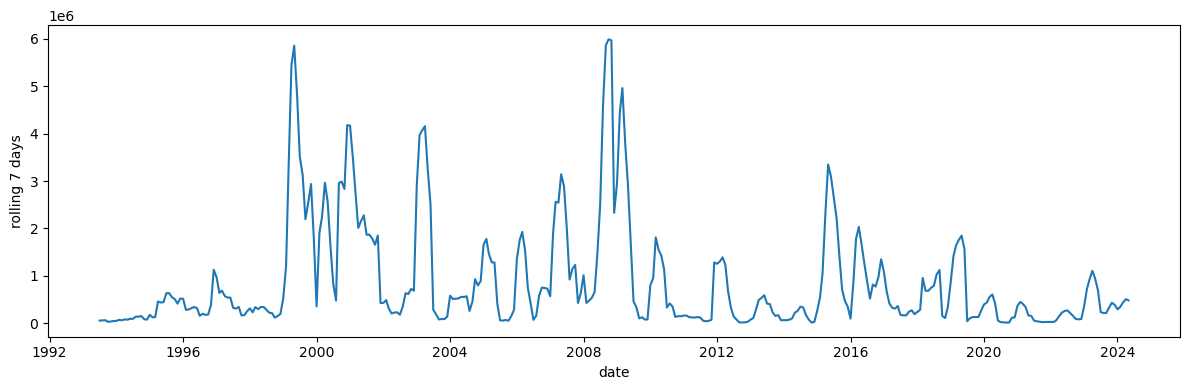

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x = df['DATE'],
             y = df['rolling_prcmucons'],
             ax = ax)

ax.set_xlabel('date')
ax.set_ylabel('rolling 7 days')
plt.tight_layout()
plt.show()

In [36]:
# calculate mean and std from rolling variance
mean_rolling_week = df['rolling_prcmucons'].mean()
std_rolling_week = df['rolling_prcmucons'].std()

In [37]:
# calculate Z-Score
df['z_score_week'] = (df['rolling_prcmucons'] - mean_rolling_week) / std_rolling_week

In [38]:
# threshold general
z_score_threshold = 3

df['anomaly_week'] = df['z_score_week'] > z_score_threshold

In [39]:
df['anomaly_week'].value_counts(normalize=True)

anomaly_week
False    0.976127
True     0.023873
Name: proportion, dtype: float64

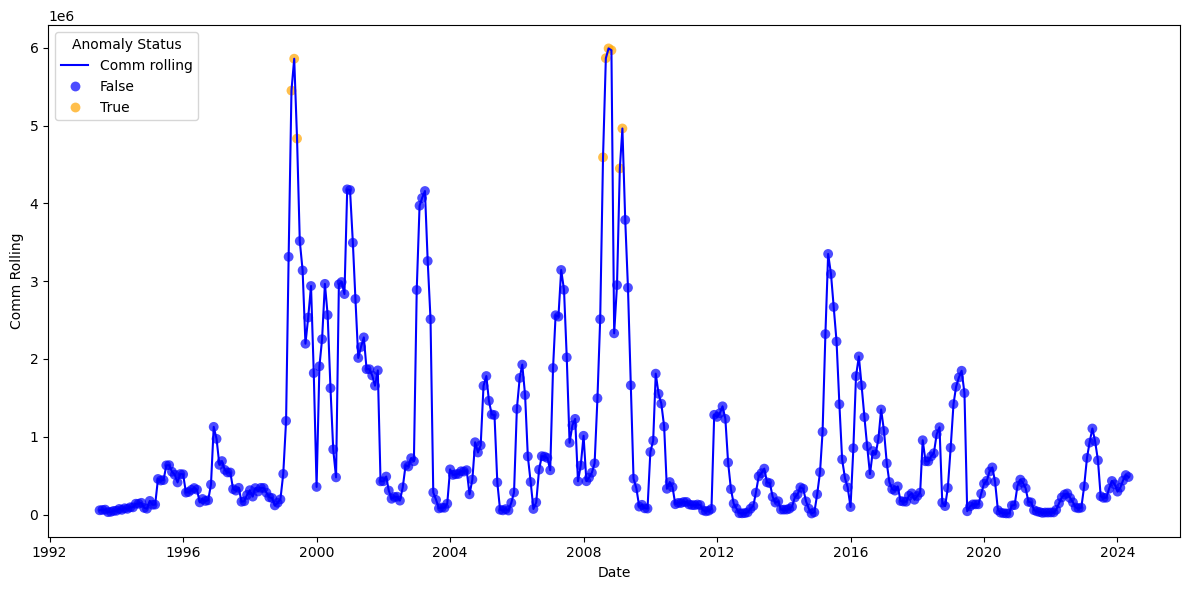

In [40]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot of comm_pct_change over time
sns.lineplot(x='DATE', y='rolling_prcmucons', data=df, ax=ax, color='b', label='Comm rolling')

# Scatter plot for anomaly status
sns.scatterplot(x='DATE', y='rolling_prcmucons', hue='anomaly_week', data=df, palette={True: 'orange', False: 'blue'}, ax=ax, legend='brief', marker='o', s=50, edgecolor='none', alpha=0.7)

# Labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('Comm Rolling')
ax.legend(loc='upper left', title='Anomaly Status')

# Display plot
plt.tight_layout()
plt.show()

**Model 4 - month by month**

If the variance of the last 30 days is large, then the anomaly

In [43]:
df['rolling_prcmucons_month'] = df['PRCMUCONS'].rolling(window=30).var()
df.head()

,DATE,PRCMUCONS,anomaly,comm_pct_change,anomaly_2,rolling_prcmucons,z_score_week,anomaly_week,rolling_prcmucons_month
0,1993-01-01,9629.0,False,0.000000,False,NaN,NaN,False,NaN
1,1993-02-01,9483.0,False,-0.015163,False,NaN,NaN,False,NaN
2,1993-03-01,10089.0,False,0.063904,False,NaN,NaN,False,NaN
3,1993-04-01,9387.0,False,-0.069581,False,NaN,NaN,False,NaN
4,1993-05-01,9630.0,False,0.025887,False,NaN,NaN,False,NaN


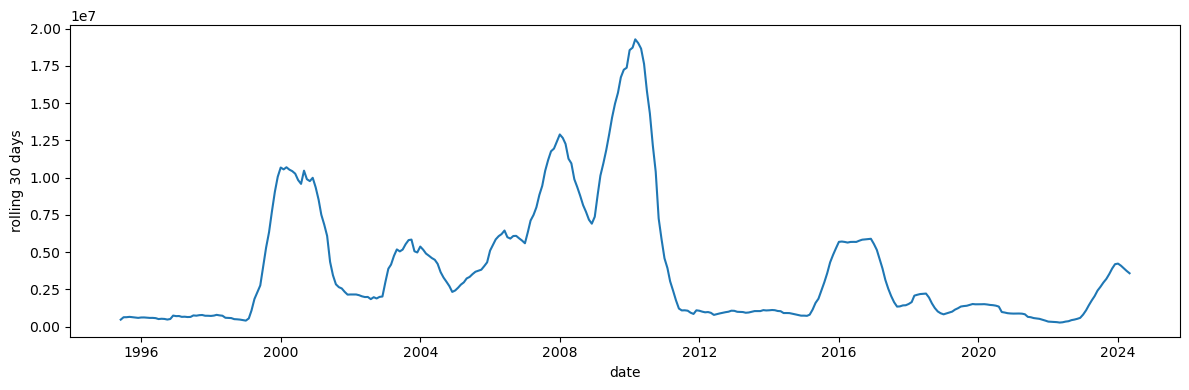

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x = df['DATE'],
             y = df['rolling_prcmucons_month'],
             ax = ax)

ax.set_xlabel('date')
ax.set_ylabel('rolling 30 days')
plt.tight_layout()
plt.show()

In [45]:
# calculate mean and std from rolling variance
mean_rolling = df['rolling_prcmucons_month'].mean()
std_rolling = df['rolling_prcmucons_month'].std()

In [46]:
# calculate Z-Score
df['z_score'] = (df['rolling_prcmucons_month'] - mean_rolling) / std_rolling

In [47]:
# threshold general
z_score_threshold = 3

df['anomaly_monthly'] = df['z_score'] > z_score_threshold

In [48]:
df['anomaly_monthly'].value_counts(normalize=True)

anomaly_monthly
False    0.976127
True     0.023873
Name: proportion, dtype: float64

We obtain 23% anomaly by month

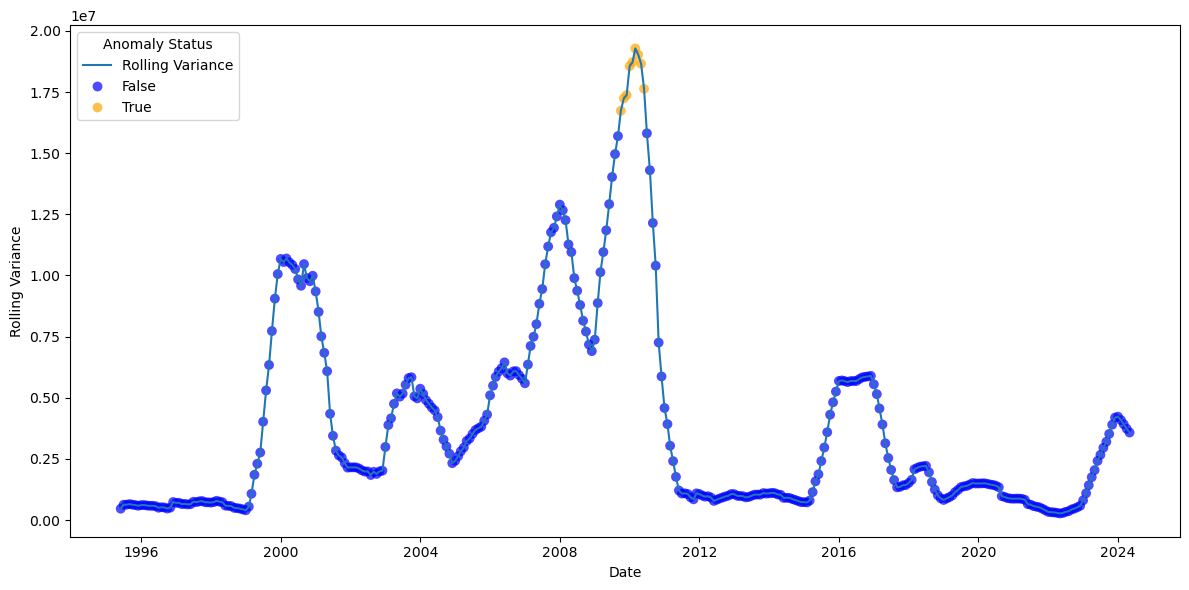

In [50]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='DATE', y='rolling_prcmucons_month', data=df, ax=ax, label='Rolling Variance')
sns.scatterplot(x='DATE', y='rolling_prcmucons_month', hue='anomaly_monthly', data=df, palette={True: 'orange', False: 'blue'}, ax=ax, legend='brief', marker='o', s=50, edgecolor='none', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Variance')
ax.legend(loc='upper left', title='Anomaly Status')
plt.tight_layout()
plt.show()

**Combine anomaly to week**

In [52]:
df['anomaly_total_week'] = df['anomaly'] | df['anomaly_2'] | df['anomaly_week']

In [53]:
df.head()

,DATE,PRCMUCONS,anomaly,comm_pct_change,anomaly_2,rolling_prcmucons,z_score_week,anomaly_week,rolling_prcmucons_month,z_score,anomaly_monthly,anomaly_total_week
0,1993-01-01,9629.0,False,0.000000,False,NaN,NaN,False,NaN,NaN,False,False
1,1993-02-01,9483.0,False,-0.015163,False,NaN,NaN,False,NaN,NaN,False,False
2,1993-03-01,10089.0,False,0.063904,False,NaN,NaN,False,NaN,NaN,False,False
3,1993-04-01,9387.0,False,-0.069581,False,NaN,NaN,False,NaN,NaN,False,False
4,1993-05-01,9630.0,False,0.025887,False,NaN,NaN,False,NaN,NaN,False,False


In [54]:
df['anomaly_total_week'].value_counts(normalize=True)

anomaly_total_week
False    0.885942
True     0.114058
Name: proportion, dtype: float64

There are 11.4% of spending communication that are anomalous

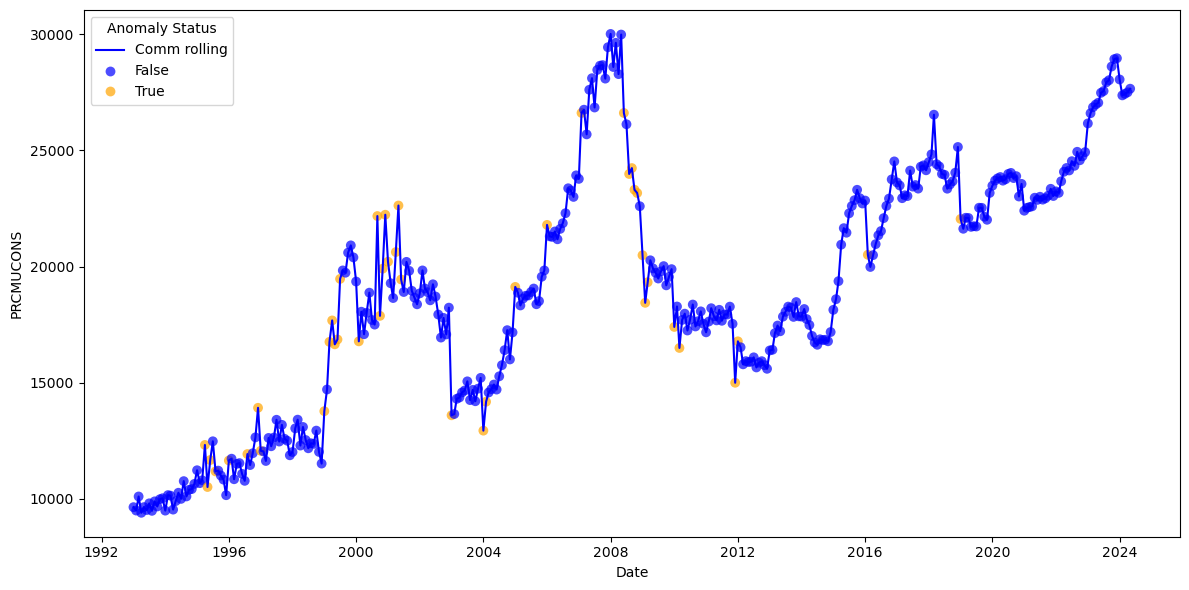

In [70]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot of comm_pct_change over time
sns.lineplot(x='DATE', y='PRCMUCONS', data=df, ax=ax, color='b', label='Comm rolling')

# Scatter plot for anomaly status
sns.scatterplot(x='DATE', y='PRCMUCONS', hue='anomaly_total_week', data=df, palette={True: 'orange', False: 'blue'}, ax=ax, legend='brief', marker='o', s=50, edgecolor='none', alpha=0.7)

# Labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('PRCMUCONS')
ax.legend(loc='upper left', title='Anomaly Status')

# Display plot
plt.tight_layout()
plt.show()

**Combine anomaly to Month**

In [65]:
df['anomaly_total_month'] = df['anomaly'] | df['anomaly_2'] | df['anomaly_week'] | df['anomaly_monthly']

In [67]:
df['anomaly_total_month'].value_counts(normalize=True)

anomaly_total_month
False    0.867374
True     0.132626
Name: proportion, dtype: float64

There are 13.2% of spending communication that are anomalous

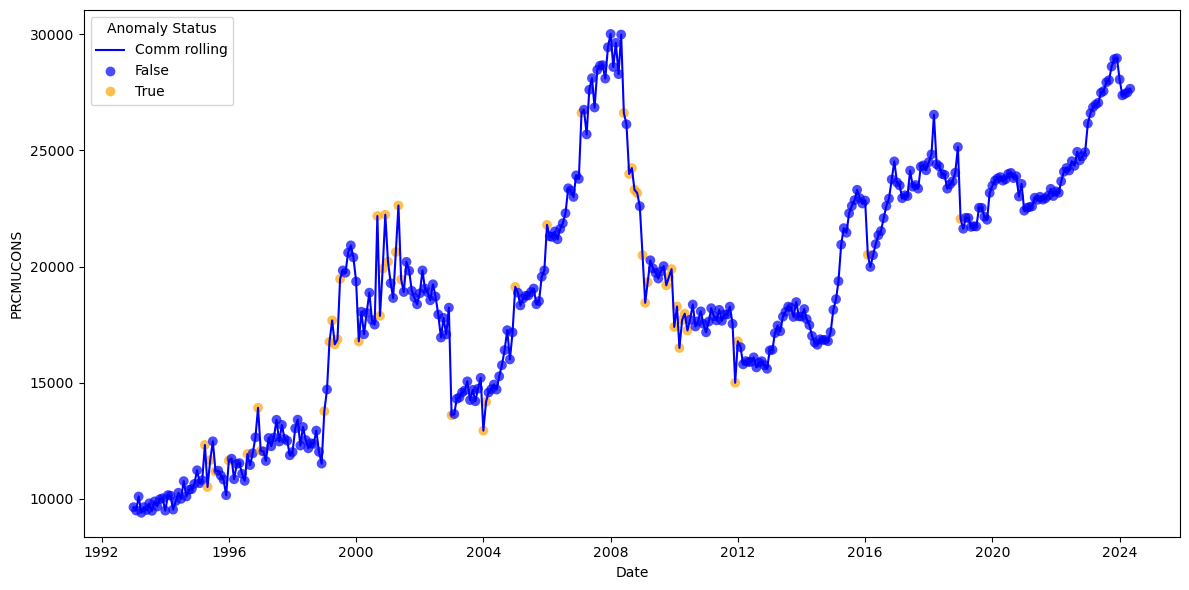

In [72]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot of comm_pct_change over time
sns.lineplot(x='DATE', y='PRCMUCONS', data=df, ax=ax, color='b', label='Comm rolling')

# Scatter plot for anomaly status
sns.scatterplot(x='DATE', y='PRCMUCONS', hue='anomaly_total_month', data=df, palette={True: 'orange', False: 'blue'}, ax=ax, legend='brief', marker='o', s=50, edgecolor='none', alpha=0.7)

# Labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('PRCMUCONS')
ax.legend(loc='upper left', title='Anomaly Status')

# Display plot
plt.tight_layout()
plt.show()

## Evaluation Model
---

- Is predicted anomaly an anomaly? (Precision)- 
Are anomalies well predictable? (Recall


But in this case we not have real label, this last step)

In [ ]:
df_copy = df.copy()

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
data_values = df_copy['PRCMUCONS'].values.reshape(-1, 1)

# Define the oulier fraction
outliers_fraction = float(0.01)

# Build and train isolation forest model
model = IsolationForest(contamination=outliers_fraction)
model.fit(data_values)

In [ ]:
# predict anomaly
anomaly_labels = model.predict(data_values)
df_copy['anomaly_iso_label'] = anomaly_labels

In [ ]:
df_copy['anomaly_iso_label'].value_counts()

In [ ]:
# tampilkan
plt.figure(figsize=(10, 6))
plt.scatter(df_copy.index, df_copy['PRCMUCONS'], c=df_copy['anomaly_iso_label'], cmap='viridis', marker='o', alpha=0.6)
plt.colorbar(label='Anomaly Label')
plt.title('Scatter Plot of Anomaly Predictions by Isolation Forest')
plt.xlabel('Index')
plt.ylabel('PRCMUCONS')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_neighbors': np.arange(3, 15, 3) 
}

# Initialize LocalOutlierFactor
lof = LocalOutlierFactor(contamination=outliers_fraction)

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
# Fit GridSearchCV
grid_search.fit(data_values)

# Get the best parameter and model
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f'Best number of neighbors: {best_n_neighbors}')

In [ ]:
# Build and train LOF model with the best parameter
best_model = LocalOutlierFactor(n_neighbors=best_n_neighbors, contamination=outliers_fraction)
anomaly_labels = best_model.fit_predict(data_values)

In [ ]:
# Convert LOF labels from -1 (anomaly) and 1 (normal) to 0 (normal) and 1 (anomaly)
df_copy['anomaly_lof_label'] = (anomaly_labels == -1).astype(int)

In [ ]:
df_copy['anomaly_lof_label'].value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_copy.index, df_copy['PRCMUCONS'], c=df_copy['anomaly_lof_label'], cmap='viridis', marker='o', alpha=0.6)
plt.colorbar(label='Anomaly Label')
plt.title('Scatter Plot of Anomaly Predictions by Local Outlier Factor with Grid Search')
plt.xlabel('Index')
plt.ylabel('PRCMUCONS')
plt.grid(True)
plt.tight_layout()
plt.show()